# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up Turi Create

Make sure you have the latest version of Turi Create

In [4]:
import turicreate

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [5]:
sales = turicreate.SFrame('home_data.sframe/')

If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook

As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [3]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [12]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe=data_sframe[features]
    
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray=data_sframe[output]
    
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [13]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions=np.dot(feature_matrix,weights)
    return(predictions)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [15]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant:
        derivative=2*np.dot(errors,feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative=2*np.dot(errors,feature)+2*l2_penalty*weight
    return derivative

To test your feature derivartive run the following:

In [16]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print (np.sum(errors*example_features[:,1])*2+20.)
print ('')

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print (np.sum(errors)*2.)

-56554166782350.0
-56554166782350.0

-22446749336.0
-22446749336.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [79]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print ('Starting gradient descent with l2_penalty = ' + str(l2_penalty))
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration<max_iterations:
        iteration += 1  # increment iteration counter
            ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===

        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions=predict_output(feature_matrix, weights)

        # compute the errors as predictions - output
        errors=predictions-output

        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print ('Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2)))

        print (len(weights))
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            print (i)
            if i==0:
                feature_is_constant=1
            else:
                feature_is_constant=0
            derivative=feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)
            # subtract the step size times the derivative from the current weight
            print (derivative)
            weights[i]=weights[i]-step_size*derivative

        print ('Done with gradient descent at iteration ', iteration)
        print ('Learned weights = ', str(weights))
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [80]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [81]:
train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [82]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [83]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [84]:
l2_penalty=0.0
simple_weights_0_penalty=ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, 
                                                           step_size, l2_penalty, max_iterations=max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7433051851026171.0
2
0
-18752698930.0
1
-47332513695884.0
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01]
Iteration = 2
Cost function =  5394267213135527.0
2
0
-15329683495.595844
1
-38814794322519.78
Done with gradient descent at iteration  2
Learned weights =  [3.40823824e-02 8.61473080e+01]
Iteration = 3
Cost function =  4023237736501158.0
2
0
-12522656579.103268
1
-31829880579448.55
Done with gradient descent at iteration  3
Learned weights =  [4.66050390e-02 1.17977189e+02]
Iteration = 4
Cost function =  3101256183922414.5
2
0
-10220768007.246634
1
-26101936530163.086
Done with gradient descent at iteration  4
Learned weights =  [5.68258070e-02 1.44079125e+02]
Iteration = 5
Cost function =  2481247644505114.0
2
0
-8333115642.400214
1
-21404764275990.22
Done with gradient descent at iteration  5
Learned weights =  [6.51589227e-02 1.65483889e+02]
Iteration = 6

2
0
268624371.6216855
1
-476261894.00961304
Done with gradient descent at iteration  59
Learned weights =  [8.98405436e-02 2.63022097e+02]
Iteration = 60
Cost function =  1208251140915263.0
2
0
268658804.8117403
1
-390575656.50819397
Done with gradient descent at iteration  60
Learned weights =  [8.95718848e-02 2.63022488e+02]
2
0
268687041.30334735
1
-320309080.2402649
Done with gradient descent at iteration  61
Learned weights =  [8.93031977e-02 2.63022808e+02]
2
0
268710196.2229644
1
-262687321.09309387
Done with gradient descent at iteration  62
Learned weights =  [8.90344875e-02 2.63023071e+02]
2
0
268729184.0245465
1
-215434881.82785034
Done with gradient descent at iteration  63
Learned weights =  [8.87657583e-02 2.63023286e+02]
2
0
268744754.60154825
1
-176685752.16064453
Done with gradient descent at iteration  64
Learned weights =  [8.84970136e-02 2.63023463e+02]
2
0
268757522.90038955
1
-144909719.58439636
Done with gradient descent at iteration  65
Learned weights =  [8.822

0
268815633.7822959
1
-113870.06507873535
Done with gradient descent at iteration  116
Learned weights =  [7.45189218e-02 2.63024273e+02]
2
0
268815632.6710205
1
-112818.92823791504
Done with gradient descent at iteration  117
Learned weights =  [7.42501062e-02 2.63024273e+02]
2
0
268815631.483733
1
-111956.93574523926
Done with gradient descent at iteration  118
Learned weights =  [7.39812906e-02 2.63024274e+02]
2
0
268815630.23410386
1
-111250.07279968262
Done with gradient descent at iteration  119
Learned weights =  [7.37124749e-02 2.63024274e+02]
2
0
268815628.9333564
1
-110670.41204833984
Done with gradient descent at iteration  120
Learned weights =  [7.34436593e-02 2.63024274e+02]
2
0
268815627.59068763
1
-110195.06503295898
Done with gradient descent at iteration  121
Learned weights =  [7.31748437e-02 2.63024274e+02]
2
0
268815626.2136435
1
-109805.25784301758
Done with gradient descent at iteration  122
Learned weights =  [7.29060281e-02 2.63024274e+02]
2
0
268815624.8084109

-108028.92362976074
Done with gradient descent at iteration  177
Learned weights =  [5.81211709e-02 2.63024280e+02]
2
0
268815541.040537
1
-108028.91513061523
Done with gradient descent at iteration  178
Learned weights =  [5.78523554e-02 2.63024280e+02]
2
0
268815539.5068444
1
-108028.90768432617
Done with gradient descent at iteration  179
Learned weights =  [5.75835399e-02 2.63024280e+02]
2
0
268815537.97315174
1
-108028.90010070801
Done with gradient descent at iteration  180
Learned weights =  [5.73147243e-02 2.63024280e+02]
2
0
268815536.43945897
1
-108028.89222717285
Done with gradient descent at iteration  181
Learned weights =  [5.70459088e-02 2.63024280e+02]
2
0
268815534.90576255
1
-108028.89479064941
Done with gradient descent at iteration  182
Learned weights =  [5.67770933e-02 2.63024281e+02]
2
0
268815533.37206656
1
-108028.89663696289
Done with gradient descent at iteration  183
Learned weights =  [5.65082777e-02 2.63024281e+02]
2
0
268815531.8383715
1
-108028.894912719

1
-108028.84217834473
Done with gradient descent at iteration  236
Learned weights =  [4.22610566e-02 2.63024286e+02]
2
0
268815450.5525388
1
-108028.85231018066
Done with gradient descent at iteration  237
Learned weights =  [4.19922412e-02 2.63024286e+02]
2
0
268815449.01884514
1
-108028.84770202637
Done with gradient descent at iteration  238
Learned weights =  [4.17234257e-02 2.63024287e+02]
2
0
268815447.4851516
1
-108028.84466552734
Done with gradient descent at iteration  239
Learned weights =  [4.14546103e-02 2.63024287e+02]
2
0
268815445.95145935
1
-108028.83825683594
Done with gradient descent at iteration  240
Learned weights =  [4.11857949e-02 2.63024287e+02]
2
0
268815444.4177626
1
-108028.84255981445
Done with gradient descent at iteration  241
Learned weights =  [4.09169794e-02 2.63024287e+02]
2
0
268815442.88406545
1
-108028.84814453125
Done with gradient descent at iteration  242
Learned weights =  [4.06481640e-02 2.63024287e+02]
2
0
268815441.3503717
1
-108028.8436431

268815356.9971622
1
-108028.83825683594
Done with gradient descent at iteration  298
Learned weights =  [2.55945016e-02 2.63024293e+02]
2
0
268815355.4634681
1
-108028.83773803711
Done with gradient descent at iteration  299
Learned weights =  [2.53256863e-02 2.63024293e+02]
Iteration = 300
Cost function =  1208251123148809.8
2
0
268815353.9297734
1
-108028.8385925293
Done with gradient descent at iteration  300
Learned weights =  [2.50568709e-02 2.63024293e+02]
2
0
268815352.3960796
1
-108028.83633422852
Done with gradient descent at iteration  301
Learned weights =  [2.47880555e-02 2.63024293e+02]
2
0
268815350.8623865
1
-108028.83308410645
Done with gradient descent at iteration  302
Learned weights =  [2.45192402e-02 2.63024294e+02]
2
0
268815349.3286926
1
-108028.83097839355
Done with gradient descent at iteration  303
Learned weights =  [2.42504248e-02 2.63024294e+02]
2
0
268815347.79499805
1
-108028.83198547363
Done with gradient descent at iteration  304
Learned weights =  [2.3

2
0
268815264.9755264
1
-108028.79035949707
Done with gradient descent at iteration  358
Learned weights =  [9.465583e-03 2.630243e+02]
2
0
268815263.4418364
1
-108028.78057861328
Done with gradient descent at iteration  359
Learned weights =  [9.19676773e-03 2.63024300e+02]
2
0
268815261.90814096
1
-108028.78427124023
Done with gradient descent at iteration  360
Learned weights =  [8.92795247e-03 2.63024300e+02]
2
0
268815260.37444675
1
-108028.78479003906
Done with gradient descent at iteration  361
Learned weights =  [8.65913721e-03 2.63024300e+02]
2
0
268815258.8407509
1
-108028.78971862793
Done with gradient descent at iteration  362
Learned weights =  [8.39032195e-03 2.63024300e+02]
2
0
268815257.3070607
1
-108028.78012084961
Done with gradient descent at iteration  363
Learned weights =  [8.12150669e-03 2.63024300e+02]
2
0
268815255.77336526
1
-108028.7837677002
Done with gradient descent at iteration  364
Learned weights =  [7.85269144e-03 2.63024300e+02]
2
0
268815254.2396712


-108028.72862243652
Done with gradient descent at iteration  418
Learned weights =  [-6.66333010e-03  2.63024306e+02]
2
0
268815171.42023104
1
-108028.73596191406
Done with gradient descent at iteration  419
Learned weights =  [-6.93214527e-03  2.63024306e+02]
2
0
268815169.88653994
1
-108028.72933959961
Done with gradient descent at iteration  420
Learned weights =  [-7.20096044e-03  2.63024306e+02]
2
0
268815168.35284805
1
-108028.72650146484
Done with gradient descent at iteration  421
Learned weights =  [-7.46977561e-03  2.63024306e+02]
2
0
268815166.8191512
1
-108028.73405456543
Done with gradient descent at iteration  422
Learned weights =  [-7.73859077e-03  2.63024306e+02]
2
0
268815165.2854596
1
-108028.72999572754
Done with gradient descent at iteration  423
Learned weights =  [-8.00740594e-03  2.63024307e+02]
2
0
268815163.7517681
1
-108028.72470092773
Done with gradient descent at iteration  424
Learned weights =  [-8.27622110e-03  2.63024307e+02]
2
0
268815162.21807235
1
-1

-108028.71903991699
Done with gradient descent at iteration  480
Learned weights =  [-2.33298678e-02  2.63024313e+02]
2
0
268815076.33125997
1
-108028.71900939941
Done with gradient descent at iteration  481
Learned weights =  [-2.35986829e-02  2.63024313e+02]
2
0
268815074.7975671
1
-108028.71896362305
Done with gradient descent at iteration  482
Learned weights =  [-2.38674980e-02  2.63024313e+02]
2
0
268815073.2638759
1
-108028.71432495117
Done with gradient descent at iteration  483
Learned weights =  [-2.41363130e-02  2.63024313e+02]
2
0
268815071.73018295
1
-108028.71447753906
Done with gradient descent at iteration  484
Learned weights =  [-2.44051281e-02  2.63024313e+02]
2
0
268815070.19649005
1
-108028.71426391602
Done with gradient descent at iteration  485
Learned weights =  [-2.46739432e-02  2.63024313e+02]
2
0
268815068.66279805
1
-108028.71304321289
Done with gradient descent at iteration  486
Learned weights =  [-2.49427583e-02  2.63024313e+02]
2
0
268815067.1291051
1
-1

268814987.37710494
1
-108028.67025756836
Done with gradient descent at iteration  539
Learned weights =  [-3.91899547e-02  2.63024319e+02]
2
0
268814985.8434101
1
-108028.67723083496
Done with gradient descent at iteration  540
Learned weights =  [-3.94587697e-02  2.63024319e+02]
2
0
268814984.30972123
1
-108028.66841125488
Done with gradient descent at iteration  541
Learned weights =  [-3.97275847e-02  2.63024319e+02]
2
0
268814982.7760271
1
-108028.67234802246
Done with gradient descent at iteration  542
Learned weights =  [-3.99963997e-02  2.63024319e+02]
2
0
268814981.24233824
1
-108028.66319274902
Done with gradient descent at iteration  543
Learned weights =  [-4.02652146e-02  2.63024320e+02]
2
0
268814979.708645
1
-108028.66590881348
Done with gradient descent at iteration  544
Learned weights =  [-4.05340296e-02  2.63024320e+02]
2
0
268814978.1749518
1
-108028.66818237305
Done with gradient descent at iteration  545
Learned weights =  [-4.08028446e-02  2.63024320e+02]
2
0
2688

-108028.62232971191
Done with gradient descent at iteration  597
Learned weights =  [-5.47812213e-02  2.63024325e+02]
2
0
268814896.8892901
1
-108028.61595153809
Done with gradient descent at iteration  598
Learned weights =  [-5.50500362e-02  2.63024325e+02]
2
0
268814895.35559833
1
-108028.61557006836
Done with gradient descent at iteration  599
Learned weights =  [-5.53188511e-02  2.63024326e+02]
Iteration = 600
Cost function =  1208251101470335.0
2
0
268814893.82190835
1
-108028.61038208008
Done with gradient descent at iteration  600
Learned weights =  [-5.55876660e-02  2.63024326e+02]
2
0
268814892.28821397
1
-108028.61712646484
Done with gradient descent at iteration  601
Learned weights =  [-5.58564809e-02  2.63024326e+02]
2
0
268814890.75452304
1
-108028.61492919922
Done with gradient descent at iteration  602
Learned weights =  [-5.61252958e-02  2.63024326e+02]
2
0
268814889.220829
1
-108028.62037658691
Done with gradient descent at iteration  603
Learned weights =  [-5.63941

2
0
268814806.40148777
1
-108028.60556030273
Done with gradient descent at iteration  657
Learned weights =  [-7.09101124e-02  2.63024332e+02]
2
0
268814804.8677949
1
-108028.60916137695
Done with gradient descent at iteration  658
Learned weights =  [-7.11789273e-02  2.63024332e+02]
2
0
268814803.33410454
1
-108028.60659790039
Done with gradient descent at iteration  659
Learned weights =  [-7.14477421e-02  2.63024332e+02]
2
0
268814801.8004128
1
-108028.60720825195
Done with gradient descent at iteration  660
Learned weights =  [-7.17165569e-02  2.63024332e+02]
2
0
268814800.26672065
1
-108028.60961914062
Done with gradient descent at iteration  661
Learned weights =  [-7.19853717e-02  2.63024332e+02]
2
0
268814798.7330306
1
-108028.60667419434
Done with gradient descent at iteration  662
Learned weights =  [-7.22541865e-02  2.63024332e+02]
2
0
268814797.1993385
1
-108028.60891723633
Done with gradient descent at iteration  663
Learned weights =  [-7.25230013e-02  2.63024333e+02]
2
0

268814717.447424
1
-108028.55213928223
Done with gradient descent at iteration  715
Learned weights =  [-8.65013686e-02  2.63024338e+02]
2
0
268814715.913731
1
-108028.5572052002
Done with gradient descent at iteration  716
Learned weights =  [-8.67701833e-02  2.63024338e+02]
2
0
268814714.3800387
1
-108028.56187438965
Done with gradient descent at iteration  717
Learned weights =  [-8.70389980e-02  2.63024338e+02]
2
0
268814712.8463499
1
-108028.55616760254
Done with gradient descent at iteration  718
Learned weights =  [-8.73078127e-02  2.63024338e+02]
2
0
268814711.3126569
1
-108028.56092834473
Done with gradient descent at iteration  719
Learned weights =  [-8.75766274e-02  2.63024339e+02]
2
0
268814709.77896875
1
-108028.55514526367
Done with gradient descent at iteration  720
Learned weights =  [-8.78454422e-02  2.63024339e+02]
2
0
268814708.2452775
1
-108028.55551147461
Done with gradient descent at iteration  721
Learned weights =  [-8.81142569e-02  2.63024339e+02]
2
0
26881470

268814626.9596883
1
-108028.52638244629
Done with gradient descent at iteration  774
Learned weights =  [-1.02361434e-01  2.63024344e+02]
2
0
268814625.4259993
1
-108028.52331542969
Done with gradient descent at iteration  775
Learned weights =  [-1.02630249e-01  2.63024345e+02]
2
0
268814623.89231014
1
-108028.52032470703
Done with gradient descent at iteration  776
Learned weights =  [-1.02899063e-01  2.63024345e+02]
2
0
268814622.358621
1
-108028.51731872559
Done with gradient descent at iteration  777
Learned weights =  [-1.03167878e-01  2.63024345e+02]
2
0
268814620.82493186
1
-108028.51455688477
Done with gradient descent at iteration  778
Learned weights =  [-1.03436693e-01  2.63024345e+02]
2
0
268814619.2912428
1
-108028.51156616211
Done with gradient descent at iteration  779
Learned weights =  [-1.03705507e-01  2.63024345e+02]
2
0
268814617.75755364
1
-108028.50866699219
Done with gradient descent at iteration  780
Learned weights =  [-1.03974322e-01  2.63024345e+02]
2
0
2688

-108028.4945526123
Done with gradient descent at iteration  832
Learned weights =  [-1.17952680e-01  2.63024351e+02]
2
0
268814536.47198415
1
-108028.49870300293
Done with gradient descent at iteration  833
Learned weights =  [-1.18221494e-01  2.63024351e+02]
2
0
268814534.9382941
1
-108028.4981842041
Done with gradient descent at iteration  834
Learned weights =  [-1.18490309e-01  2.63024351e+02]
2
0
268814533.4046038
1
-108028.49932861328
Done with gradient descent at iteration  835
Learned weights =  [-1.18759124e-01  2.63024351e+02]
2
0
268814531.8709126
1
-108028.50358581543
Done with gradient descent at iteration  836
Learned weights =  [-1.19027938e-01  2.63024351e+02]
2
0
268814530.3372267
1
-108028.49285888672
Done with gradient descent at iteration  837
Learned weights =  [-1.19296753e-01  2.63024351e+02]
2
0
268814528.80353725
1
-108028.4926147461
Done with gradient descent at iteration  838
Learned weights =  [-1.19565567e-01  2.63024351e+02]
2
0
268814527.2698478
1
-108028

2
0
268814449.0516996
1
-108028.44306945801
Done with gradient descent at iteration  890
Learned weights =  [-1.33543921e-01  2.63024357e+02]
2
0
268814447.51800936
1
-108028.44548034668
Done with gradient descent at iteration  891
Learned weights =  [-1.33812735e-01  2.63024357e+02]
2
0
268814445.9843212
1
-108028.443359375
Done with gradient descent at iteration  892
Learned weights =  [-1.34081549e-01  2.63024357e+02]
2
0
268814444.4506292
1
-108028.4496307373
Done with gradient descent at iteration  893
Learned weights =  [-1.34350364e-01  2.63024357e+02]
2
0
268814442.91694295
1
-108028.44203186035
Done with gradient descent at iteration  894
Learned weights =  [-1.34619178e-01  2.63024357e+02]
2
0
268814441.3832526
1
-108028.44395446777
Done with gradient descent at iteration  895
Learned weights =  [-1.34887993e-01  2.63024358e+02]
2
0
268814439.8495605
1
-108028.45109558105
Done with gradient descent at iteration  896
Learned weights =  [-1.35156807e-01  2.63024358e+02]
2
0
268

2
0
268814360.09773654
1
-108028.43435668945
Done with gradient descent at iteration  948
Learned weights =  [-1.49135156e-01  2.63024363e+02]
2
0
268814358.5640476
1
-108028.43394470215
Done with gradient descent at iteration  949
Learned weights =  [-1.49403970e-01  2.63024363e+02]
2
0
268814357.0303594
1
-108028.43286132812
Done with gradient descent at iteration  950
Learned weights =  [-1.49672785e-01  2.63024364e+02]
2
0
268814355.496672
1
-108028.42877197266
Done with gradient descent at iteration  951
Learned weights =  [-1.49941599e-01  2.63024364e+02]
2
0
268814353.96298385
1
-108028.42781066895
Done with gradient descent at iteration  952
Learned weights =  [-1.50210413e-01  2.63024364e+02]
2
0
268814352.4292946
1
-108028.42845153809
Done with gradient descent at iteration  953
Learned weights =  [-1.50479228e-01  2.63024364e+02]
2
0
268814350.89560646
1
-108028.42744445801
Done with gradient descent at iteration  954
Learned weights =  [-1.50748042e-01  2.63024364e+02]
2
0


Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [85]:
l2_penalty=1e11
simple_weights_high_penalty=ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, 
                                                           step_size, l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051851026171.0
2
0
-18752698930.0
1
-47332513695884.0
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01]
Iteration = 2
Cost function =  5618303898412632.0
2
0
-15329683495.595844
1
-29348291583342.984
Done with gradient descent at iteration  2
Learned weights =  [3.40823824e-02 7.66808053e+01]
Iteration = 3
Cost function =  4920613278115386.0
2
0
-13207259535.585331
1
-18197263127042.73
Done with gradient descent at iteration  3
Learned weights =  [4.72896420e-02 9.48780684e+01]
Iteration = 4
Cost function =  4652381942612294.0
2
0
-11891260921.649239
1
-11283122784741.918
Done with gradient descent at iteration  4
Learned weights =  [5.91809029e-02 1.06161191e+02]
Iteration = 5
Cost function =  4549258764014157.0
2
0
-11075282376.731693
1
-6996044076228.574
Done with gradient descent at iteration  5
Learned weights =  [7.02561853e-02 1.13157235e+02]


Learned weights =  [  0.57910102 124.57392448]
2
0
-9743683674.059385
1
1854487.98828125
Done with gradient descent at iteration  58
Learned weights =  [  0.58884471 124.57392262]
2
0
-9743683469.404716
1
1854514.43359375
Done with gradient descent at iteration  59
Learned weights =  [  0.59858839 124.57392077]
Iteration = 60
Cost function =  4484845032293500.0
2
0
-9743683264.751968
1
1854530.81640625
Done with gradient descent at iteration  60
Learned weights =  [  0.60833208 124.57391891]
2
0
-9743683060.100412
1
1854540.96484375
Done with gradient descent at iteration  61
Learned weights =  [  0.61807576 124.57391706]
2
0
-9743682855.449596
1
1854547.23828125
Done with gradient descent at iteration  62
Learned weights =  [  0.62781944 124.5739152 ]
2
0
-9743682650.799242
1
1854551.11328125
Done with gradient descent at iteration  63
Learned weights =  [  0.63756312 124.57391335]
2
0
-9743682446.149176
1
1854553.5
Done with gradient descent at iteration  64
Learned weights =  [  0.6

2
0
-9743671395.076164
1
1854555.36328125
Done with gradient descent at iteration  118
Learned weights =  [  1.17346535 124.57381135]
2
0
-9743671190.426798
1
1854555.32421875
Done with gradient descent at iteration  119
Learned weights =  [  1.18320903 124.57380949]
2
0
-9743670985.777431
1
1854555.2890625
Done with gradient descent at iteration  120
Learned weights =  [  1.1929527  124.57380764]
2
0
-9743670781.128073
1
1854555.24609375
Done with gradient descent at iteration  121
Learned weights =  [  1.20269637 124.57380579]
2
0
-9743670576.478718
1
1854555.19921875
Done with gradient descent at iteration  122
Learned weights =  [  1.21244004 124.57380393]
2
0
-9743670371.829365
1
1854555.171875
Done with gradient descent at iteration  123
Learned weights =  [  1.22218371 124.57380208]
2
0
-9743670167.18002
1
1854555.13671875
Done with gradient descent at iteration  124
Learned weights =  [  1.23192738 124.57380022]
2
0
-9743669962.530678
1
1854555.08984375
Done with gradient desce

1854552.91015625
Done with gradient descent at iteration  181
Learned weights =  [  1.78731624 124.57369451]
2
0
-9743658297.525272
1
1854552.875
Done with gradient descent at iteration  182
Learned weights =  [  1.7970599  124.57369266]
2
0
-9743658092.87618
1
1854552.83203125
Done with gradient descent at iteration  183
Learned weights =  [  1.80680356 124.5736908 ]
2
0
-9743657888.227093
1
1854552.7890625
Done with gradient descent at iteration  184
Learned weights =  [  1.81654721 124.57368895]
2
0
-9743657683.578009
1
1854552.7578125
Done with gradient descent at iteration  185
Learned weights =  [  1.82629087 124.57368709]
2
0
-9743657478.92893
1
1854552.703125
Done with gradient descent at iteration  186
Learned weights =  [  1.83603453 124.57368524]
2
0
-9743657274.279852
1
1854552.671875
Done with gradient descent at iteration  187
Learned weights =  [  1.84577819 124.57368338]
2
0
-9743657069.630783
1
1854552.625
Done with gradient descent at iteration  188
Learned weights = 

-9743645609.289639
1
1854550.453125
Done with gradient descent at iteration  244
Learned weights =  [  2.40116631 124.57357768]
2
0
-9743645404.640808
1
1854550.42578125
Done with gradient descent at iteration  245
Learned weights =  [  2.41090996 124.57357582]
2
0
-9743645199.991987
1
1854550.38671875
Done with gradient descent at iteration  246
Learned weights =  [  2.4206536  124.57357397]
2
0
-9743644995.34317
1
1854550.33984375
Done with gradient descent at iteration  247
Learned weights =  [  2.43039725 124.57357211]
2
0
-9743644790.694359
1
1854550.296875
Done with gradient descent at iteration  248
Learned weights =  [  2.44014089 124.57357026]
2
0
-9743644586.04555
1
1854550.26171875
Done with gradient descent at iteration  249
Learned weights =  [  2.44988454 124.5735684 ]
2
0
-9743644381.396744
1
1854550.2265625
Done with gradient descent at iteration  250
Learned weights =  [  2.45962818 124.57356655]
2
0
-9743644176.747946
1
1854550.19140625
Done with gradient descent at i

2
0
-9743632921.07052
1
1854548.04296875
Done with gradient descent at iteration  306
Learned weights =  [  3.00527194 124.57346269]
2
0
-9743632716.421965
1
1854548.0
Done with gradient descent at iteration  307
Learned weights =  [  3.01501557 124.57346084]
2
0
-9743632511.77341
1
1854547.9609375
Done with gradient descent at iteration  308
Learned weights =  [  3.02475921 124.57345898]
2
0
-9743632307.124859
1
1854547.93359375
Done with gradient descent at iteration  309
Learned weights =  [  3.03450284 124.57345713]
2
0
-9743632102.476315
1
1854547.89453125
Done with gradient descent at iteration  310
Learned weights =  [  3.04424647 124.57345528]
2
0
-9743631897.827772
1
1854547.83984375
Done with gradient descent at iteration  311
Learned weights =  [  3.0539901  124.57345342]
2
0
-9743631693.17923
1
1854547.8125
Done with gradient descent at iteration  312
Learned weights =  [  3.06373373 124.57345157]
2
0
-9743631488.530697
1
1854547.7578125
Done with gradient descent at iterat

1854545.63671875
Done with gradient descent at iteration  368
Learned weights =  [  3.60937678 124.57334771]
2
0
-9743620028.219643
1
1854545.58203125
Done with gradient descent at iteration  369
Learned weights =  [  3.6191204  124.57334586]
2
0
-9743619823.57135
1
1854545.546875
Done with gradient descent at iteration  370
Learned weights =  [  3.62886402 124.573344  ]
2
0
-9743619618.923063
1
1854545.5078125
Done with gradient descent at iteration  371
Learned weights =  [  3.63860764 124.57334215]
2
0
-9743619414.274786
1
1854545.48046875
Done with gradient descent at iteration  372
Learned weights =  [  3.64835126 124.57334029]
2
0
-9743619209.626509
1
1854545.43359375
Done with gradient descent at iteration  373
Learned weights =  [  3.65809488 124.57333844]
2
0
-9743619004.97824
1
1854545.390625
Done with gradient descent at iteration  374
Learned weights =  [  3.6678385  124.57333658]
2
0
-9743618800.329971
1
1854545.35546875
Done with gradient descent at iteration  375
Learned

2
0
-9743607340.033842
1
1854543.171875
Done with gradient descent at iteration  431
Learned weights =  [  4.22322444 124.57323088]
2
0
-9743607135.385818
1
1854543.125
Done with gradient descent at iteration  432
Learned weights =  [  4.23296805 124.57322902]
2
0
-9743606930.7378
1
1854543.09765625
Done with gradient descent at iteration  433
Learned weights =  [  4.24271166 124.57322717]
2
0
-9743606726.089787
1
1854543.0546875
Done with gradient descent at iteration  434
Learned weights =  [  4.25245527 124.57322531]
2
0
-9743606521.441778
1
1854543.01953125
Done with gradient descent at iteration  435
Learned weights =  [  4.26219887 124.57322346]
2
0
-9743606316.79377
1
1854542.97265625
Done with gradient descent at iteration  436
Learned weights =  [  4.27194248 124.5732216 ]
2
0
-9743606112.14577
1
1854542.93359375
Done with gradient descent at iteration  437
Learned weights =  [  4.28168608 124.57321975]
2
0
-9743605907.49777
1
1854542.8984375
Done with gradient descent at iter

2
0
-9743593423.978086
1
1854540.5234375
Done with gradient descent at iteration  499
Learned weights =  [  4.88578926 124.57310477]
Iteration = 500
Cost function =  4484803259357623.5
2
0
-9743593219.33036
1
1854540.48046875
Done with gradient descent at iteration  500
Learned weights =  [  4.89553286 124.57310291]
2
0
-9743593014.68263
1
1854540.44140625
Done with gradient descent at iteration  501
Learned weights =  [  4.90527645 124.57310106]
2
0
-9743592810.034908
1
1854540.40234375
Done with gradient descent at iteration  502
Learned weights =  [  4.91502004 124.5730992 ]
2
0
-9743592605.387194
1
1854540.35546875
Done with gradient descent at iteration  503
Learned weights =  [  4.92476364 124.57309735]
2
0
-9743592400.73948
1
1854540.328125
Done with gradient descent at iteration  504
Learned weights =  [  4.93450723 124.57309549]
2
0
-9743592196.09177
1
1854540.29296875
Done with gradient descent at iteration  505
Learned weights =  [  4.94425082 124.57309364]
2
0
-9743591991.4

-9743579917.237104
1
1854537.953125
Done with gradient descent at iteration  565
Learned weights =  [  5.52886598 124.57298237]
2
0
-9743579712.589657
1
1854537.9140625
Done with gradient descent at iteration  566
Learned weights =  [  5.53860956 124.57298051]
2
0
-9743579507.942215
1
1854537.859375
Done with gradient descent at iteration  567
Learned weights =  [  5.54835314 124.57297866]
2
0
-9743579303.294773
1
1854537.8359375
Done with gradient descent at iteration  568
Learned weights =  [  5.55809672 124.5729768 ]
2
0
-9743579098.647343
1
1854537.80078125
Done with gradient descent at iteration  569
Learned weights =  [  5.56784029 124.57297495]
2
0
-9743578893.999912
1
1854537.76171875
Done with gradient descent at iteration  570
Learned weights =  [  5.57758387 124.57297309]
2
0
-9743578689.352486
1
1854537.71875
Done with gradient descent at iteration  571
Learned weights =  [  5.58732745 124.57297124]
2
0
-9743578484.705067
1
1854537.6796875
Done with gradient descent at iter

1854535.49609375
Done with gradient descent at iteration  628
Learned weights =  [  6.1427111  124.57286553]
2
0
-9743566819.809174
1
1854535.453125
Done with gradient descent at iteration  629
Learned weights =  [  6.15245467 124.57286368]
2
0
-9743566615.162006
1
1854535.42578125
Done with gradient descent at iteration  630
Learned weights =  [  6.16219823 124.57286182]
2
0
-9743566410.514837
1
1854535.375
Done with gradient descent at iteration  631
Learned weights =  [  6.1719418  124.57285997]
2
0
-9743566205.867676
1
1854535.34375
Done with gradient descent at iteration  632
Learned weights =  [  6.18168537 124.57285811]
2
0
-9743566001.220518
1
1854535.30859375
Done with gradient descent at iteration  633
Learned weights =  [  6.19142893 124.57285626]
2
0
-9743565796.57336
1
1854535.265625
Done with gradient descent at iteration  634
Learned weights =  [  6.2011725 124.5728544]
2
0
-9743565591.926212
1
1854535.2265625
Done with gradient descent at iteration  635
Learned weights 

2
0
-9743554336.339573
1
1854533.08203125
Done with gradient descent at iteration  690
Learned weights =  [  6.74681185 124.57275055]
2
0
-9743554131.692663
1
1854533.046875
Done with gradient descent at iteration  691
Learned weights =  [  6.75655541 124.5727487 ]
2
0
-9743553927.045761
1
1854533.0078125
Done with gradient descent at iteration  692
Learned weights =  [  6.76629896 124.57274684]
2
0
-9743553722.398859
1
1854532.96484375
Done with gradient descent at iteration  693
Learned weights =  [  6.77604252 124.57274499]
2
0
-9743553517.751963
1
1854532.92578125
Done with gradient descent at iteration  694
Learned weights =  [  6.78578607 124.57274313]
2
0
-9743553313.10507
1
1854532.890625
Done with gradient descent at iteration  695
Learned weights =  [  6.79552962 124.57274128]
2
0
-9743553108.458183
1
1854532.85546875
Done with gradient descent at iteration  696
Learned weights =  [  6.80527318 124.57273942]
2
0
-9743552903.8113
1
1854532.80859375
Done with gradient descent a

2
0
-9743541648.239317
1
1854530.6640625
Done with gradient descent at iteration  752
Learned weights =  [  7.35091182 124.57263557]
2
0
-9743541443.592674
1
1854530.6328125
Done with gradient descent at iteration  753
Learned weights =  [  7.36065537 124.57263371]
2
0
-9743541238.946037
1
1854530.58203125
Done with gradient descent at iteration  754
Learned weights =  [  7.37039891 124.57263186]
2
0
-9743541034.2994
1
1854530.546875
Done with gradient descent at iteration  755
Learned weights =  [  7.38014245 124.57263001]
2
0
-9743540829.65277
1
1854530.51953125
Done with gradient descent at iteration  756
Learned weights =  [  7.38988599 124.57262815]
2
0
-9743540625.006145
1
1854530.4765625
Done with gradient descent at iteration  757
Learned weights =  [  7.39962953 124.5726263 ]
2
0
-9743540420.359528
1
1854530.4296875
Done with gradient descent at iteration  758
Learned weights =  [  7.40937307 124.57262444]
2
0
-9743540215.712908
1
1854530.39453125
Done with gradient descent at

1854528.24609375
Done with gradient descent at iteration  814
Learned weights =  [  7.95501101 124.57252059]
2
0
-9743528755.509203
1
1854528.21484375
Done with gradient descent at iteration  815
Learned weights =  [  7.96475454 124.57251873]
2
0
-9743528550.862833
1
1854528.171875
Done with gradient descent at iteration  816
Learned weights =  [  7.97449806 124.57251688]
2
0
-9743528346.216463
1
1854528.140625
Done with gradient descent at iteration  817
Learned weights =  [  7.98424159 124.57251502]
2
0
-9743528141.5701
1
1854528.109375
Done with gradient descent at iteration  818
Learned weights =  [  7.99398512 124.57251317]
2
0
-9743527936.923742
1
1854528.0546875
Done with gradient descent at iteration  819
Learned weights =  [  8.00372865 124.57251132]
2
0
-9743527732.27739
1
1854528.03125
Done with gradient descent at iteration  820
Learned weights =  [  8.01347218 124.57250946]
2
0
-9743527527.631039
1
1854527.98046875
Done with gradient descent at iteration  821
Learned weigh

Done with gradient descent at iteration  881
Learned weights =  [  8.60782698 124.57239633]
2
0
-9743515044.211775
1
1854525.60546875
Done with gradient descent at iteration  882
Learned weights =  [  8.6175705  124.57239448]
2
0
-9743514839.565691
1
1854525.56640625
Done with gradient descent at iteration  883
Learned weights =  [  8.62731401 124.57239263]
2
0
-9743514634.919611
1
1854525.5234375
Done with gradient descent at iteration  884
Learned weights =  [  8.63705753 124.57239077]
2
0
-9743514430.273537
1
1854525.48046875
Done with gradient descent at iteration  885
Learned weights =  [  8.64680104 124.57238892]
2
0
-9743514225.627462
1
1854525.45703125
Done with gradient descent at iteration  886
Learned weights =  [  8.65654455 124.57238706]
2
0
-9743514020.981398
1
1854525.4140625
Done with gradient descent at iteration  887
Learned weights =  [  8.66628807 124.57238521]
2
0
-9743513816.335335
1
1854525.3828125
Done with gradient descent at iteration  888
Learned weights =  [

1854522.98828125
Done with gradient descent at iteration  949
Learned weights =  [  9.27038554 124.57227023]
2
0
-9743501128.287844
1
1854522.9609375
Done with gradient descent at iteration  950
Learned weights =  [  9.28012904 124.57226837]
2
0
-9743500923.642054
1
1854522.9140625
Done with gradient descent at iteration  951
Learned weights =  [  9.28987254 124.57226652]
2
0
-9743500718.996267
1
1854522.875
Done with gradient descent at iteration  952
Learned weights =  [  9.29961604 124.57226466]
2
0
-9743500514.350477
1
1854522.83203125
Done with gradient descent at iteration  953
Learned weights =  [  9.30935954 124.57226281]
2
0
-9743500309.704702
1
1854522.7890625
Done with gradient descent at iteration  954
Learned weights =  [  9.31910304 124.57226095]
2
0
-9743500105.058926
1
1854522.765625
Done with gradient descent at iteration  955
Learned weights =  [  9.32884654 124.5722591 ]
2
0
-9743499900.413157
1
1854522.71484375
Done with gradient descent at iteration  956
Learned we

This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

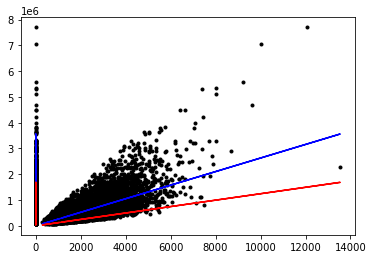

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [49]:
initial_predictions=predict_output(simple_test_feature_matrix, initial_weights)
initial_error=initial_predictions-test_output
initial_RSS=initial_error*initial_error
print (initial_RSS.sum())

1784273282524564.0


In [50]:
predictions_0_penalty=predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
error_0_penalt=predictions_0_penalty-test_output
RSS_0_penalt=error_0_penalt*error_0_penalt
print (RSS_0_penalt.sum())

275723634587181.94


In [51]:
predictions_high_penalty=predict_output(simple_test_feature_matrix, simple_weights_high_penalty)
error_high_penalt=predictions_high_penalty-test_output
RSS_high_penalt=error_high_penalt*error_high_penalt
print (RSS_high_penalt.sum())

694642088704277.8


***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?
3. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [87]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [88]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [89]:
l2_penalty=0.0
multiple_weights_0_penalty=ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                                           step_size, l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7433051851026171.0
3
0
-18752698930.0
1
-47332513695884.0
2
-42391128023186.0
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01 4.23911280e+01]
Iteration = 2
Cost function =  4056752331500973.5
3
0
-12402615359.7794
1
-32021202347118.51
2
-28297899212429.562
Done with gradient descent at iteration  2
Learned weights =  [3.11553143e-02 7.93537160e+01 7.06890272e+01]
Iteration = 3
Cost function =  2529565114333592.0
3
0
-8132946958.582469
1
-21723814498160.363
2
-18821998631521.81
Done with gradient descent at iteration  3
Learned weights =  [3.92882612e-02 1.01077531e+02 8.95110259e+01]
Iteration = 4
Cost function =  1838556694275927.0
3
0
-5262272159.304802
1
-14798097959301.566
2
-12451060694015.836
Done with gradient descent at iteration  4
Learned weights =  [4.45505334e-02 1.15875629e+02 1.01962087e+02]
Iteration = 5
Cost function =  1525675575208603.5
3
0
-3332

498877830480.1044
Done with gradient descent at iteration  45
Learned weights =  [3.18802175e-02 1.66322257e+02 1.05736506e+02]
3
0
576480491.434351
1
-456698390080.4978
2
495919060565.6781
Done with gradient descent at iteration  46
Learned weights =  [3.13037370e-02 1.66778955e+02 1.05240587e+02]
3
0
575265446.4755589
1
-453989185559.09515
2
492977722294.96893
Done with gradient descent at iteration  47
Learned weights =  [3.07284716e-02 1.67232945e+02 1.04747609e+02]
3
0
574057572.7278556
1
-451296137429.346
2
490053751090.64404
Done with gradient descent at iteration  48
Learned weights =  [3.01544140e-02 1.67684241e+02 1.04257555e+02]
3
0
572856839.4166027
1
-448619121511.71484
2
487147070043.4126
Done with gradient descent at iteration  49
Learned weights =  [2.95815571e-02 1.68132860e+02 1.03770408e+02]
Iteration = 50
Cost function =  1242139508748821.2
3
0
571663212.0972009
1
-445958023647.92316
2
484257594149.8286
Done with gradient descent at iteration  50
Learned weights =  

-349430886341.71826
2
379440783694.7543
Done with gradient descent at iteration  91
Learned weights =  [6.51701593e-03 1.84755707e+02 8.57199544e+01]
3
0
527434087.48439986
1
-347358211191.512
2
377190101625.35284
Done with gradient descent at iteration  92
Learned weights =  [5.98958184e-03 1.85103065e+02 8.53427643e+01]
3
0
526509854.89324737
1
-345297830267.5245
2
374952769643.3949
Done with gradient descent at iteration  93
Learned weights =  [5.46307199e-03 1.85448363e+02 8.49678115e+01]
3
0
525591104.44801724
1
-343249670645.63324
2
372728708561.85547
Done with gradient descent at iteration  94
Learned weights =  [4.93748088e-03 1.85791613e+02 8.45950828e+01]
3
0
524677803.6309524
1
-341213659834.28534
2
370517839663.4002
Done with gradient descent at iteration  95
Learned weights =  [4.41280308e-03 1.86132826e+02 8.42245650e+01]
3
0
523769920.11717755
1
-339189725771.9164
2
368320084697.61304
Done with gradient descent at iteration  96
Learned weights =  [3.88903316e-03 1.864720

288597669119.8078
Done with gradient descent at iteration  137
Learned weights =  [-1.68665380e-02  1.98775947e+02  7.04956266e+01]
3
0
490129758.3701038
1
-264196123178.03967
2
286885829714.99274
Done with gradient descent at iteration  138
Learned weights =  [-1.73566677e-02  1.99040143e+02  7.02087408e+01]
3
0
489426798.79511386
1
-262629024340.5071
2
285184144212.43774
Done with gradient descent at iteration  139
Learned weights =  [-1.78460945e-02  1.99302772e+02  6.99235566e+01]
3
0
488728008.86875296
1
-261071220865.8402
2
283492552383.5133
Done with gradient descent at iteration  140
Learned weights =  [-1.83348225e-02  1.99563843e+02  6.96400641e+01]
3
0
488033363.8584446
1
-259522657617.89392
2
281810994356.85535
Done with gradient descent at iteration  141
Learned weights =  [-1.88228559e-02  1.99823366e+02  6.93582531e+01]
3
0
487342839.1783093
1
-257983279787.58728
2
280139410616.215
Done with gradient descent at iteration  142
Learned weights =  [-1.93101987e-02  2.000813

Learned weights =  [-3.87443962e-02  2.09439558e+02  5.89162034e+01]
3
0
461756557.39371574
1
-200944124513.52975
2
218201579202.31305
Done with gradient descent at iteration  184
Learned weights =  [-3.92061527e-02  2.09640502e+02  5.86980018e+01]
3
0
461221895.1866384
1
-199752209592.36212
2
216907299420.42993
Done with gradient descent at iteration  185
Learned weights =  [-3.96673746e-02  2.09840254e+02  5.84810945e+01]
3
0
460690404.3598851
1
-198567364602.85535
2
215620696754.9663
Done with gradient descent at iteration  186
Learned weights =  [-4.01280650e-02  2.10038822e+02  5.82654738e+01]
3
0
460162066.1021769
1
-197389547609.19196
2
214341725668.53265
Done with gradient descent at iteration  187
Learned weights =  [-4.05882271e-02  2.10236211e+02  5.80511321e+01]
3
0
459636861.71381885
1
-196218716924.28888
2
213070340893.85703
Done with gradient descent at iteration  188
Learned weights =  [-4.10478640e-02  2.10432430e+02  5.78380617e+01]
3
0
459114772.6060312
1
-1950548311

-152835479930.104
2
165961234767.9926
Done with gradient descent at iteration  230
Learned weights =  [-5.99172175e-02  2.17702997e+02  4.99430857e+01]
3
0
439769598.4791455
1
-151928924998.60876
2
164976822459.564
Done with gradient descent at iteration  231
Learned weights =  [-6.03569871e-02  2.17854926e+02  4.97781089e+01]
3
0
439365353.1638687
1
-151027747364.85895
2
163998249265.67432
Done with gradient descent at iteration  232
Learned weights =  [-6.07963524e-02  2.18005954e+02  4.96141106e+01]
3
0
438963505.6514586
1
-150131915133.0133
2
163025480551.1836
Done with gradient descent at iteration  233
Learned weights =  [-6.12353159e-02  2.18156086e+02  4.94510851e+01]
3
0
438564041.7191738
1
-149241396596.41653
2
162058481886.40015
Done with gradient descent at iteration  234
Learned weights =  [-6.16738800e-02  2.18305327e+02  4.92890267e+01]
3
0
438166947.2286276
1
-148356160236.49905
2
161097219045.8391
Done with gradient descent at iteration  235
Learned weights =  [-6.2112

3
0
423762545.1015767
1
-116244672801.14165
2
126227910661.72604
Done with gradient descent at iteration  276
Learned weights =  [-7.97624139e-02  2.23835226e+02  4.32842126e+01]
3
0
423453246.4417052
1
-115555158953.11055
2
125479179509.04285
Done with gradient descent at iteration  277
Learned weights =  [-8.01858672e-02  2.23950781e+02  4.31587334e+01]
3
0
423145782.40157795
1
-114869735007.56161
2
124734889510.6589
Done with gradient descent at iteration  278
Learned weights =  [-8.06090130e-02  2.24065651e+02  4.30339985e+01]
3
0
422840142.09901506
1
-114188376704.92479
2
123995014323.54659
Done with gradient descent at iteration  279
Learned weights =  [-8.10318531e-02  2.24179839e+02  4.29100035e+01]
3
0
422536314.7163826
1
-113511059929.53938
2
123259527760.92557
Done with gradient descent at iteration  280
Learned weights =  [-8.14543894e-02  2.24293350e+02  4.27867440e+01]
3
0
422234289.5002113
1
-112837760708.78706
2
122528403791.34372
Done with gradient descent at iteration

94871690568.54448
Done with gradient descent at iteration  324
Learned weights =  [-9.97708941e-02  2.28674577e+02  3.80292529e+01]
3
0
410576907.0630612
1
-86850190531.88223
2
94308951158.4904
Done with gradient descent at iteration  325
Learned weights =  [-1.00181471e-01  2.28761427e+02  3.79349439e+01]
3
0
410345819.5917929
1
-86335032233.2439
2
93749549678.9479
Done with gradient descent at iteration  326
Learned weights =  [-1.00591817e-01  2.28847762e+02  3.78411944e+01]
3
0
410116102.82481074
1
-85822929634.22122
2
93193466330.72688
Done with gradient descent at iteration  327
Learned weights =  [-1.01001933e-01  2.28933585e+02  3.77480009e+01]
3
0
409887748.63167936
1
-85313864609.71202
2
92640681432.08026
Done with gradient descent at iteration  328
Learned weights =  [-1.01411821e-01  2.29018899e+02  3.76553602e+01]
3
0
409660748.93019336
1
-84807819142.11058
2
92091175418.01619
Done with gradient descent at iteration  329
Learned weights =  [-1.01821481e-01  2.29103707e+02 

3
0
401249635.39218134
1
-66057122962.09747
2
71730118994.42189
Done with gradient descent at iteration  371
Learned weights =  [-1.18839050e-01  2.32246123e+02  3.41509803e+01]
3
0
401073872.9480502
1
-65665300284.298065
2
71304645530.6989
Done with gradient descent at iteration  372
Learned weights =  [-1.19240124e-01  2.32311789e+02  3.40796757e+01]
3
0
400899153.04371107
1
-65275801731.73399
2
70881695794.35562
Done with gradient descent at iteration  373
Learned weights =  [-1.19641023e-01  2.32377064e+02  3.40087940e+01]
3
0
400725469.49525905
1
-64888613518.69348
2
70461254815.70834
Done with gradient descent at iteration  374
Learned weights =  [-1.20041749e-01  2.32441953e+02  3.39383327e+01]
3
0
400552816.1554711
1
-64503721941.22902
2
70043307713.87238
Done with gradient descent at iteration  375
Learned weights =  [-1.20442301e-01  2.32506457e+02  3.38682894e+01]
3
0
400381186.9135908
1
-64121113376.67023
2
69627839696.23853
Done with gradient descent at iteration  376
Lear

54233344399.11139
Done with gradient descent at iteration  418
Learned weights =  [-1.37516412e-01  2.34946482e+02  3.12187154e+01]
3
0
393888846.17583585
1
-49647924441.81726
2
53911654350.22302
Done with gradient descent at iteration  419
Learned weights =  [-1.37910300e-01  2.34996130e+02  3.11648037e+01]
3
0
393756744.40613484
1
-49353434140.77588
2
53591872429.69908
Done with gradient descent at iteration  420
Learned weights =  [-1.38304057e-01  2.35045483e+02  3.11112119e+01]
3
0
393625426.19969606
1
-49060690630.77725
2
53273987319.32538
Done with gradient descent at iteration  421
Learned weights =  [-1.38697683e-01  2.35094544e+02  3.10579379e+01]
3
0
393494886.9087575
1
-48769683550.599365
2
52957987768.034164
Done with gradient descent at iteration  422
Learned weights =  [-1.39091177e-01  2.35143314e+02  3.10049799e+01]
3
0
393365121.9131264
1
-48480402600.47229
2
52643862591.49841
Done with gradient descent at iteration  423
Learned weights =  [-1.39484543e-01  2.35191794

3
0
388257241.8397587
1
-37093586400.416306
2
40279115975.77139
Done with gradient descent at iteration  468
Learned weights =  [-1.57063373e-01  2.37100103e+02  2.88801438e+01]
3
0
388158543.9480809
1
-36873563085.61211
2
40040196466.63388
Done with gradient descent at iteration  469
Learned weights =  [-1.57451531e-01  2.37136977e+02  2.88401036e+01]
3
0
388060431.48209
1
-36654844855.40144
2
39802694126.26584
Done with gradient descent at iteration  470
Learned weights =  [-1.57839592e-01  2.37173632e+02  2.88003009e+01]
3
0
387962900.9692919
1
-36437423968.57347
2
39566600548.630325
Done with gradient descent at iteration  471
Learned weights =  [-1.58227554e-01  2.37210069e+02  2.87607343e+01]
3
0
387865948.9577874
1
-36221292729.840775
2
39331907377.54521
Done with gradient descent at iteration  472
Learned weights =  [-1.58615420e-01  2.37246290e+02  2.87214024e+01]
3
0
387769572.0161487
1
-36006443489.573105
2
39098606306.38426
Done with gradient descent at iteration  473
Learn

384198473.53786767
1
-28045552449.62668
2
30454012522.23947
Done with gradient descent at iteration  515
Learned weights =  [-1.75209615e-01  2.38616457e+02  2.72335690e+01]
3
0
384123850.14709073
1
-27879198218.55835
2
30273371342.174057
Done with gradient descent at iteration  516
Learned weights =  [-1.75593739e-01  2.38644336e+02  2.72032956e+01]
3
0
384049669.3823127
1
-27713830729.94139
2
30093801648.647095
Done with gradient descent at iteration  517
Learned weights =  [-1.75977789e-01  2.38672050e+02  2.71732018e+01]
3
0
383975928.6180684
1
-27549444130.831406
2
29915297086.064926
Done with gradient descent at iteration  518
Learned weights =  [-1.76361765e-01  2.38699600e+02  2.71432865e+01]
3
0
383902625.24445987
1
-27386032603.01584
2
29737851336.518936
Done with gradient descent at iteration  519
Learned weights =  [-1.76745667e-01  2.38726986e+02  2.71135487e+01]
3
0
383829756.6670729
1
-27223590362.783432
2
29561458119.583817
Done with gradient descent at iteration  520
L

Learned weights =  [-1.92808809e-01  2.39741731e+02  2.60116615e+01]
3
0
381129722.5969739
1
-21204555931.279358
2
23025492814.69272
Done with gradient descent at iteration  562
Learned weights =  [-1.93189939e-01  2.39762935e+02  2.59886360e+01]
3
0
381073301.34577
1
-21078779577.901123
2
22888914449.6465
Done with gradient descent at iteration  563
Learned weights =  [-1.93571012e-01  2.39784014e+02  2.59657471e+01]
3
0
381017214.75322556
1
-20953749276.289124
2
22753146209.28534
Done with gradient descent at iteration  564
Learned weights =  [-1.93952029e-01  2.39804968e+02  2.59429939e+01]
3
0
380961460.8342909
1
-20829460601.171143
2
22618183288.303467
Done with gradient descent at iteration  565
Learned weights =  [-1.94332991e-01  2.39825797e+02  2.59203758e+01]
3
0
380906037.6156868
1
-20705909153.539383
2
22484020909.88565
Done with gradient descent at iteration  566
Learned weights =  [-1.94713897e-01  2.39846503e+02  2.58978917e+01]
3
0
380850943.13584125
1
-20583090560.4697

2
17512851010.102478
Done with gradient descent at iteration  608
Learned weights =  [-2.10666004e-01  2.40613727e+02  2.50647835e+01]
3
0
378809499.4972188
1
-16032246276.097443
2
17408971288.345383
Done with gradient descent at iteration  609
Learned weights =  [-2.11044814e-01  2.40629760e+02  2.50473745e+01]
3
0
378766840.4372384
1
-15937149860.65625
2
17305707736.85135
Done with gradient descent at iteration  610
Learned weights =  [-2.11423581e-01  2.40645697e+02  2.50300688e+01]
3
0
378724434.40446424
1
-15842617516.64473
2
17203056700.76712
Done with gradient descent at iteration  611
Learned weights =  [-2.11802305e-01  2.40661539e+02  2.50128658e+01]
3
0
378682279.8980449
1
-15748645898.23706
2
17101014546.907684
Done with gradient descent at iteration  612
Learned weights =  [-2.12180988e-01  2.40677288e+02  2.49957648e+01]
3
0
378640375.4260332
1
-15655231679.447083
2
16999577663.643616
Done with gradient descent at iteration  613
Learned weights =  [-2.12559628e-01  2.4069

-12193918916.95111
2
13240998047.17453
Done with gradient descent at iteration  655
Learned weights =  [-2.28427785e-01  2.41273023e+02  2.43488741e+01]
3
0
377055219.9364649
1
-12121589824.61493
2
13162457137.765533
Done with gradient descent at iteration  656
Learned weights =  [-2.28804840e-01  2.41285144e+02  2.43357117e+01]
3
0
377022966.1316778
1
-12049689757.654358
2
13084382099.575256
Done with gradient descent at iteration  657
Learned weights =  [-2.29181863e-01  2.41297194e+02  2.43226273e+01]
3
0
376990903.63455564
1
-11978216171.261505
2
13006770169.264084
Done with gradient descent at iteration  658
Learned weights =  [-2.29558854e-01  2.41309172e+02  2.43096205e+01]
3
0
376959031.3103387
1
-11907166535.746094
2
12929618599.863937
Done with gradient descent at iteration  659
Learned weights =  [-2.29935813e-01  2.41321079e+02  2.42966909e+01]
3
0
376927348.03100365
1
-11836538336.409714
2
12852924660.711838
Done with gradient descent at iteration  660
Learned weights =  [

3
0
375704449.75615907
1
-9110476534.695816
2
9892741336.0289
Done with gradient descent at iteration  704
Learned weights =  [ -0.24686886 241.78977492  23.78774992]
3
0
375680207.75260985
1
-9056437109.304764
2
9834060859.367752
Done with gradient descent at iteration  705
Learned weights =  [ -0.24724454 241.79883136  23.77791586]
3
0
375656109.5341323
1
-9002718222.764801
2
9775728450.30484
Done with gradient descent at iteration  706
Learned weights =  [ -0.24762019 241.80783407  23.76814013]
3
0
375632154.247852
1
-8949317973.782059
2
9717742044.246582
Done with gradient descent at iteration  707
Learned weights =  [ -0.24799583 241.81678339  23.75842239]
3
0
375608341.0459592
1
-8896234472.32866
2
9660099588.855515
Done with gradient descent at iteration  708
Learned weights =  [ -0.24837143 241.82567963  23.74876229]
3
0
375584669.0856654
1
-8843465839.601318
2
9602799043.955597
Done with gradient descent at iteration  709
Learned weights =  [ -0.24874702 241.83452309  23.73915

374652874.20901465
1
-6766361482.256592
2
7347307375.206772
Done with gradient descent at iteration  754
Learned weights =  [ -0.26562596 242.1826239   23.36117038]
3
0
374634869.2952298
1
-6726226348.971832
2
7303725328.67366
Done with gradient descent at iteration  755
Learned weights =  [ -0.2660006  242.18935012  23.35386666]
3
0
374616971.170756
1
-6686329280.200714
2
7260401792.2812805
Done with gradient descent at iteration  756
Learned weights =  [ -0.26637521 242.19603645  23.34660626]
3
0
374599179.2021633
1
-6646668863.848434
2
7217335232.6549225
Done with gradient descent at iteration  757
Learned weights =  [ -0.26674981 242.20268312  23.33938892]
3
0
374581492.75978065
1
-6607243696.194534
2
7174524125.517578
Done with gradient descent at iteration  758
Learned weights =  [ -0.2671244  242.20929036  23.3322144 ]
3
0
374563911.21766907
1
-6568052381.849091
2
7131966955.629059
Done with gradient descent at iteration  759
Learned weights =  [ -0.26749896 242.21585842  23.325

3
0
373845184.3874174
1
-4965944981.577011
2
5392266260.797516
Done with gradient descent at iteration  806
Learned weights =  [ -0.28508543 242.48435482  23.0335347 ]
3
0
373831969.9208057
1
-4936489152.156631
2
5360280685.482025
Done with gradient descent at iteration  807
Learned weights =  [ -0.28545926 242.48929131  23.02817442]
3
0
373818833.8286134
1
-4907208042.168137
2
5328484834.979401
Done with gradient descent at iteration  808
Learned weights =  [ -0.28583308 242.49419852  23.02284594]
3
0
373805775.64595306
1
-4878100615.257004
2
5296877583.915436
Done with gradient descent at iteration  809
Learned weights =  [ -0.28620688 242.49907662  23.01754906]
3
0
373792794.91070265
1
-4849165841.20076
2
5265457813.607513
Done with gradient descent at iteration  810
Learned weights =  [ -0.28658068 242.50392578  23.0122836 ]
3
0
373779891.1634738
1
-4820402695.904297
2
5234224411.991669
Done with gradient descent at iteration  811
Learned weights =  [ -0.28695446 242.50874619  23.0

Learned weights =  [ -0.30301581 242.69109081  22.80905171]
3
0
373281833.1876332
1
-3710221317.510544
2
4028697669.509323
Done with gradient descent at iteration  855
Learned weights =  [ -0.30338909 242.69480103  22.80502301]
3
0
373271959.88006675
1
-3688213906.041443
2
4004800202.317169
Done with gradient descent at iteration  856
Learned weights =  [ -0.30376236 242.69848924  22.80101821]
3
0
373262145.12858635
1
-3666337033.1630554
2
3981044484.7232666
Done with gradient descent at iteration  857
Learned weights =  [ -0.30413562 242.70215558  22.79703717]
3
0
373252388.58586305
1
-3644589924.571762
2
3957429675.9324036
Done with gradient descent at iteration  858
Learned weights =  [ -0.30450888 242.70580017  22.79307974]
3
0
373242689.9066238
1
-3622971810.571335
2
3933954940.12529
Done with gradient descent at iteration  859
Learned weights =  [ -0.30488212 242.70942314  22.78914578]
3
0
373233048.74764925
1
-3601481926.0143585
2
3910619446.4539795
Done with gradient descent at

372860918.0543774
1
-2772029186.658615
2
3009931073.92955
Done with gradient descent at iteration  904
Learned weights =  [ -0.32166888 242.85203234  22.63429646]
3
0
372853541.03577507
1
-2755586731.3236084
2
2992076496.2787933
Done with gradient descent at iteration  905
Learned weights =  [ -0.32204173 242.85478793  22.63130438]
3
0
372846207.766338
1
-2739241805.623642
2
2974327824.38414
Done with gradient descent at iteration  906
Learned weights =  [ -0.32241458 242.85752717  22.62833005]
3
0
372838917.9865595
1
-2722993831.0674744
2
2956684430.0466003
Done with gradient descent at iteration  907
Learned weights =  [ -0.32278741 242.86025016  22.62537337]
3
0
372831671.4384814
1
-2706842232.5721436
2
2939145688.8134155
Done with gradient descent at iteration  908
Learned weights =  [ -0.32316025 242.86295701  22.62243422]
3
0
372824467.86567044
1
-2690786438.479187
2
2921710979.9237976
Done with gradient descent at iteration  909
Learned weights =  [ -0.32353307 242.86564779  22.

-2071075227.1339111
2
2248777302.205536
Done with gradient descent at iteration  953
Learned weights =  [ -0.33993083 242.96950507  22.50674305]
3
0
372540909.5952844
1
-2058790532.1390686
2
2235437564.548538
Done with gradient descent at iteration  954
Learned weights =  [ -0.34030337 242.97156386  22.50450762]
3
0
372535430.3220655
1
-2046578704.7194672
2
2222176952.5364532
Done with gradient descent at iteration  955
Learned weights =  [ -0.3406759  242.97361044  22.50228544]
3
0
372529983.54139066
1
-2034439312.660843
2
2208994996.8255463
Done with gradient descent at iteration  956
Learned weights =  [ -0.34104843 242.97564488  22.50007644]
3
0
372524569.0605287
1
-2022371926.3057709
2
2195891230.8608856
Done with gradient descent at iteration  957
Learned weights =  [ -0.34142096 242.97766725  22.49788055]
3
0
372519186.6878902
1
-2010376118.5502777
2
2182865190.852646
Done with gradient descent at iteration  958
Learned weights =  [ -0.34179348 242.97967763  22.49569769]
3
0
372

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [90]:
l2_penalty=1e11
multiple_weights_high_penalty=ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                                           step_size, l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051851026171.0
3
0
-18752698930.0
1
-47332513695884.0
2
-42391128023186.0
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01 4.23911280e+01]
Iteration = 2
Cost function =  4460489790285892.5
3
0
-12402615359.7794
1
-22554699607941.71
2
-19819673607792.363
Done with gradient descent at iteration  2
Learned weights =  [3.11553143e-02 6.98872133e+01 6.22108016e+01]
Iteration = 3
Cost function =  3796674468844607.5
3
0
-9402963542.22782
1
-10808633835915.035
2
-9198483808506.12
Done with gradient descent at iteration  3
Learned weights =  [4.05582778e-02 8.06958471e+01 7.14092854e+01]
Iteration = 4
Cost function =  3648319530437361.0
3
0
-7986152607.555171
1
-5227692909444.076
2
-4214479894001.0215
Done with gradient descent at iteration  4
Learned weights =  [4.85444304e-02 8.59235400e+01 7.56237653e+01]
Iteration = 5
Cost function =  3615091103216103.0
3

-6720227967.400342
1
-13872364.98828125
2
16943737.884765625
Done with gradient descent at iteration  47
Learned weights =  [ 0.33863665 91.49007146 78.43751292]
3
0
-6720227900.472712
1
-10830894.64453125
2
13641057.294921875
Done with gradient descent at iteration  48
Learned weights =  [ 0.34535688 91.49008229 78.43749928]
3
0
-6720227825.452519
1
-8415759.07421875
2
11018502.908203125
Done with gradient descent at iteration  49
Learned weights =  [ 0.35207711 91.4900907  78.43748826]
Iteration = 50
Cost function =  3605292631106357.5
3
0
-6720227744.006274
1
-6497976.19921875
2
8936015.271484375
Done with gradient descent at iteration  50
Learned weights =  [ 0.35879734 91.4900972  78.43747932]
3
0
-6720227657.457304
1
-4975125.35546875
2
7282377.580078125
Done with gradient descent at iteration  51
Learned weights =  [ 0.36551757 91.49010218 78.43747204]
3
0
-6720227566.856423
1
-3765877.60546875
2
5969276.095703125
Done with gradient descent at iteration  52
Learned weights =  [ 

-6720222846.978102
1
896814.03515625
2
906137.6953125
Done with gradient descent at iteration  97
Learned weights =  [ 0.67464793 91.49008356 78.43740578]
3
0
-6720222740.75358
1
896843.9453125
2
906105.185546875
Done with gradient descent at iteration  98
Learned weights =  [ 0.68136815 91.49008266 78.43740487]
3
0
-6720222634.528976
1
896867.6953125
2
906079.37109375
Done with gradient descent at iteration  99
Learned weights =  [ 0.68808837 91.49008177 78.43740397]
Iteration = 100
Cost function =  3605290373034643.0
3
0
-6720222528.304313
1
896886.5390625
2
906058.875
Done with gradient descent at iteration  100
Learned weights =  [ 0.69480859 91.49008087 78.43740306]
3
0
-6720222422.079601
1
896901.515625
2
906042.59765625
Done with gradient descent at iteration  101
Learned weights =  [ 0.70152882 91.49007997 78.43740215]
3
0
-6720222315.854851
1
896913.390625
2
906029.658203125
Done with gradient descent at iteration  102
Learned weights =  [ 0.70824904 91.49007907 78.43740125]
3

905979.173828125
Done with gradient descent at iteration  149
Learned weights =  [ 1.02409937 91.49003692 78.43735867]
3
0
-6720217217.062031
1
896958.578125
2
905979.1640625
Done with gradient descent at iteration  150
Learned weights =  [ 1.03081958 91.49003602 78.43735776]
3
0
-6720217110.837209
1
896958.5625
2
905979.14453125
Done with gradient descent at iteration  151
Learned weights =  [ 1.0375398  91.49003512 78.43735685]
3
0
-6720217004.61239
1
896958.546875
2
905979.123046875
Done with gradient descent at iteration  152
Learned weights =  [ 1.04426002 91.49003423 78.43735595]
3
0
-6720216898.38757
1
896958.53515625
2
905979.12109375
Done with gradient descent at iteration  153
Learned weights =  [ 1.05098024 91.49003333 78.43735504]
3
0
-6720216792.162755
1
896958.515625
2
905979.095703125
Done with gradient descent at iteration  154
Learned weights =  [ 1.05770045 91.49003243 78.43735414]
3
0
-6720216685.937938
1
896958.515625
2
905979.083984375
Done with gradient descent at

3
0
-6720211799.598268
1
896957.86328125
2
905978.4375
Done with gradient descent at iteration  201
Learned weights =  [ 1.37355052 91.48999028 78.43731155]
3
0
-6720211693.373531
1
896957.83984375
2
905978.4140625
Done with gradient descent at iteration  202
Learned weights =  [ 1.38027073 91.48998938 78.43731065]
3
0
-6720211587.148798
1
896957.83203125
2
905978.3984375
Done with gradient descent at iteration  203
Learned weights =  [ 1.38699095 91.48998848 78.43730974]
3
0
-6720211480.924064
1
896957.8203125
2
905978.388671875
Done with gradient descent at iteration  204
Learned weights =  [ 1.39371116 91.48998759 78.43730884]
3
0
-6720211374.699332
1
896957.80078125
2
905978.375
Done with gradient descent at iteration  205
Learned weights =  [ 1.40043137 91.48998669 78.43730793]
3
0
-6720211268.474606
1
896957.78125
2
905978.35546875
Done with gradient descent at iteration  206
Learned weights =  [ 1.40715158 91.48998579 78.43730702]
3
0
-6720211162.249878
1
896957.77734375
2
90597

3
0
-6720206169.689571
1
896957.11328125
2
905977.671875
Done with gradient descent at iteration  254
Learned weights =  [ 1.7297216  91.48994274 78.43726354]
3
0
-6720206063.464925
1
896957.08984375
2
905977.65234375
Done with gradient descent at iteration  255
Learned weights =  [ 1.7364418  91.48994184 78.43726263]
3
0
-6720205957.240282
1
896957.078125
2
905977.634765625
Done with gradient descent at iteration  256
Learned weights =  [ 1.74316201 91.48994094 78.43726173]
3
0
-6720205851.015633
1
896957.0703125
2
905977.62109375
Done with gradient descent at iteration  257
Learned weights =  [ 1.74988221 91.48994005 78.43726082]
3
0
-6720205744.790992
1
896957.04296875
2
905977.61328125
Done with gradient descent at iteration  258
Learned weights =  [ 1.75660242 91.48993915 78.43725991]
3
0
-6720205638.566353
1
896957.03125
2
905977.59765625
Done with gradient descent at iteration  259
Learned weights =  [ 1.76332262 91.48993825 78.43725901]
3
0
-6720205532.341713
1
896957.015625
2


3
0
-6720200646.010154
1
896956.3671875
2
905976.92578125
Done with gradient descent at iteration  306
Learned weights =  [ 2.07917217 91.4898961  78.43721643]
3
0
-6720200539.785593
1
896956.34765625
2
905976.908203125
Done with gradient descent at iteration  307
Learned weights =  [ 2.08589237 91.4898952  78.43721552]
3
0
-6720200433.561036
1
896956.33984375
2
905976.8984375
Done with gradient descent at iteration  308
Learned weights =  [ 2.09261257 91.4898943  78.43721462]
3
0
-6720200327.33648
1
896956.32421875
2
905976.875
Done with gradient descent at iteration  309
Learned weights =  [ 2.09933277 91.4898934  78.43721371]
3
0
-6720200221.111923
1
896956.3203125
2
905976.861328125
Done with gradient descent at iteration  310
Learned weights =  [ 2.10605297 91.48989251 78.4372128 ]
3
0
-6720200114.88737
1
896956.29296875
2
905976.84765625
Done with gradient descent at iteration  311
Learned weights =  [ 2.11277317 91.48989161 78.4372119 ]
3
0
-6720200008.662818
1
896956.28125
2
90

3
0
-6720195016.110802
1
896955.62109375
2
905976.1640625
Done with gradient descent at iteration  359
Learned weights =  [ 2.43534265 91.48984856 78.43716841]
3
0
-6720194909.88633
1
896955.60546875
2
905976.150390625
Done with gradient descent at iteration  360
Learned weights =  [ 2.44206285 91.48984766 78.4371675 ]
3
0
-6720194803.661862
1
896955.578125
2
905976.134765625
Done with gradient descent at iteration  361
Learned weights =  [ 2.44878304 91.48984676 78.4371666 ]
3
0
-6720194697.437393
1
896955.578125
2
905976.125
Done with gradient descent at iteration  362
Learned weights =  [ 2.45550324 91.48984587 78.43716569]
3
0
-6720194591.212928
1
896955.55859375
2
905976.103515625
Done with gradient descent at iteration  363
Learned weights =  [ 2.46222343 91.48984497 78.43716479]
3
0
-6720194484.988464
1
896955.5390625
2
905976.091796875
Done with gradient descent at iteration  364
Learned weights =  [ 2.46894363 91.48984407 78.43716388]
3
0
-6720194378.764
1
896955.54296875
2
90

-6720189492.440549
1
896954.87890625
2
905975.42578125
Done with gradient descent at iteration  411
Learned weights =  [ 2.78479265 91.48980192 78.4371213 ]
3
0
-6720189386.216165
1
896954.8671875
2
905975.404296875
Done with gradient descent at iteration  412
Learned weights =  [ 2.79151284 91.48980102 78.43712039]
3
0
-6720189279.991784
1
896954.84765625
2
905975.39453125
Done with gradient descent at iteration  413
Learned weights =  [ 2.79823303 91.48980012 78.43711949]
3
0
-6720189173.767405
1
896954.84375
2
905975.375
Done with gradient descent at iteration  414
Learned weights =  [ 2.80495321 91.48979922 78.43711858]
3
0
-6720189067.543025
1
896954.8203125
2
905975.36328125
Done with gradient descent at iteration  415
Learned weights =  [ 2.8116734  91.48979833 78.43711768]
3
0
-6720188961.318649
1
896954.8125
2
905975.34765625
Done with gradient descent at iteration  416
Learned weights =  [ 2.81839359 91.48979743 78.43711677]
3
0
-6720188855.094273
1
896954.79296875
2
905975.3

896954.14453125
2
905974.677734375
Done with gradient descent at iteration  463
Learned weights =  [ 3.13424235 91.48975527 78.43707419]
3
0
-6720183862.550541
1
896954.125
2
905974.66015625
Done with gradient descent at iteration  464
Learned weights =  [ 3.14096254 91.48975438 78.43707328]
3
0
-6720183756.326245
1
896954.11328125
2
905974.650390625
Done with gradient descent at iteration  465
Learned weights =  [ 3.14768272 91.48975348 78.43707238]
3
0
-6720183650.1019535
1
896954.1015625
2
905974.638671875
Done with gradient descent at iteration  466
Learned weights =  [ 3.15440291 91.48975258 78.43707147]
3
0
-6720183543.877664
1
896954.08984375
2
905974.6171875
Done with gradient descent at iteration  467
Learned weights =  [ 3.16112309 91.48975169 78.43707057]
3
0
-6720183437.653374
1
896954.06640625
2
905974.60546875
Done with gradient descent at iteration  468
Learned weights =  [ 3.16784327 91.48975079 78.43706966]
3
0
-6720183331.429086
1
896954.0546875
2
905974.591796875
Don

3
0
-6720178551.337875
1
896953.421875
2
905973.9453125
Done with gradient descent at iteration  514
Learned weights =  [ 3.4769716  91.48970953 78.43702798]
3
0
-6720178445.1136675
1
896953.41015625
2
905973.93359375
Done with gradient descent at iteration  515
Learned weights =  [ 3.48369177 91.48970863 78.43702708]
3
0
-6720178338.889458
1
896953.39453125
2
905973.912109375
Done with gradient descent at iteration  516
Learned weights =  [ 3.49041195 91.48970773 78.43702617]
3
0
-6720178232.665248
1
896953.37890625
2
905973.90625
Done with gradient descent at iteration  517
Learned weights =  [ 3.49713213 91.48970684 78.43702527]
3
0
-6720178126.441044
1
896953.359375
2
905973.88671875
Done with gradient descent at iteration  518
Learned weights =  [ 3.50385231 91.48970594 78.43702436]
3
0
-6720178020.216841
1
896953.3515625
2
905973.876953125
Done with gradient descent at iteration  519
Learned weights =  [ 3.51057249 91.48970504 78.43702345]
3
0
-6720177913.9926405
1
896953.3359375

896952.66796875
2
905973.185546875
Done with gradient descent at iteration  567
Learned weights =  [ 3.83314091 91.48966199 78.43697997]
3
0
-6720172815.232914
1
896952.6484375
2
905973.171875
Done with gradient descent at iteration  568
Learned weights =  [ 3.83986108 91.48966109 78.43697906]
3
0
-6720172709.008792
1
896952.64453125
2
905973.1640625
Done with gradient descent at iteration  569
Learned weights =  [ 3.84658125 91.4896602  78.43697816]
3
0
-6720172602.784675
1
896952.62890625
2
905973.142578125
Done with gradient descent at iteration  570
Learned weights =  [ 3.85330142 91.4896593  78.43697725]
3
0
-6720172496.560557
1
896952.61328125
2
905973.134765625
Done with gradient descent at iteration  571
Learned weights =  [ 3.8600216  91.4896584  78.43697634]
3
0
-6720172390.336445
1
896952.59765625
2
905973.109375
Done with gradient descent at iteration  572
Learned weights =  [ 3.86674177 91.48965751 78.43697544]
3
0
-6720172284.112331
1
896952.58203125
2
905973.099609375
Do

3
0
-6720167397.804945
1
896951.93359375
2
905972.44140625
Done with gradient descent at iteration  619
Learned weights =  [ 4.18258975 91.48961535 78.43693286]
3
0
-6720167291.580912
1
896951.9140625
2
905972.423828125
Done with gradient descent at iteration  620
Learned weights =  [ 4.18930992 91.48961445 78.43693195]
3
0
-6720167185.356877
1
896951.90234375
2
905972.4140625
Done with gradient descent at iteration  621
Learned weights =  [ 4.19603009 91.48961355 78.43693105]
3
0
-6720167079.132845
1
896951.88671875
2
905972.396484375
Done with gradient descent at iteration  622
Learned weights =  [ 4.20275025 91.48961266 78.43693014]
3
0
-6720166972.908818
1
896951.87890625
2
905972.380859375
Done with gradient descent at iteration  623
Learned weights =  [ 4.20947042 91.48961176 78.43692923]
3
0
-6720166866.6847925
1
896951.86328125
2
905972.369140625
Done with gradient descent at iteration  624
Learned weights =  [ 4.21619059 91.48961086 78.43692833]
3
0
-6720166760.460765
1
896951

3
0
-6720161874.157392
1
896951.1953125
2
905971.69921875
Done with gradient descent at iteration  671
Learned weights =  [ 4.53203831 91.48956871 78.43688575]
3
0
-6720161767.933447
1
896951.1796875
2
905971.685546875
Done with gradient descent at iteration  672
Learned weights =  [ 4.53875847 91.48956781 78.43688484]
3
0
-6720161661.709501
1
896951.1640625
2
905971.66796875
Done with gradient descent at iteration  673
Learned weights =  [ 4.54547863 91.48956691 78.43688393]
3
0
-6720161555.485557
1
896951.15625
2
905971.650390625
Done with gradient descent at iteration  674
Learned weights =  [ 4.5521988  91.48956602 78.43688303]
3
0
-6720161449.261615
1
896951.140625
2
905971.634765625
Done with gradient descent at iteration  675
Learned weights =  [ 4.55891896 91.48956512 78.43688212]
3
0
-6720161343.037674
1
896951.12890625
2
905971.62890625
Done with gradient descent at iteration  676
Learned weights =  [ 4.56563912 91.48956422 78.43688122]
3
0
-6720161236.813741
1
896951.1054687

3
0
-6720155925.618956
1
896950.40234375
2
905970.89453125
Done with gradient descent at iteration  727
Learned weights =  [ 4.90836721 91.48951848 78.43683501]
3
0
-6720155819.395103
1
896950.390625
2
905970.8828125
Done with gradient descent at iteration  728
Learned weights =  [ 4.91508736 91.48951758 78.43683411]
3
0
-6720155713.17125
1
896950.375
2
905970.869140625
Done with gradient descent at iteration  729
Learned weights =  [ 4.92180752 91.48951668 78.4368332 ]
3
0
-6720155606.947401
1
896950.35546875
2
905970.85546875
Done with gradient descent at iteration  730
Learned weights =  [ 4.92852767 91.48951579 78.43683229]
3
0
-6720155500.723554
1
896950.34765625
2
905970.83984375
Done with gradient descent at iteration  731
Learned weights =  [ 4.93524783 91.48951489 78.43683139]
3
0
-6720155394.499708
1
896950.33203125
2
905970.82421875
Done with gradient descent at iteration  732
Learned weights =  [ 4.94196798 91.48951399 78.43683048]
3
0
-6720155288.275865
1
896950.30859375
2

896949.65625
2
905970.134765625
Done with gradient descent at iteration  780
Learned weights =  [ 5.26453532 91.48947094 78.436787  ]
3
0
-6720150189.533305
1
896949.63671875
2
905970.119140625
Done with gradient descent at iteration  781
Learned weights =  [ 5.27125547 91.48947004 78.43678609]
3
0
-6720150083.309545
1
896949.61328125
2
905970.099609375
Done with gradient descent at iteration  782
Learned weights =  [ 5.27797562 91.48946915 78.43678518]
3
0
-6720149977.085781
1
896949.60546875
2
905970.08984375
Done with gradient descent at iteration  783
Learned weights =  [ 5.28469577 91.48946825 78.43678428]
3
0
-6720149870.862023
1
896949.59375
2
905970.076171875
Done with gradient descent at iteration  784
Learned weights =  [ 5.29141592 91.48946735 78.43678337]
3
0
-6720149764.6382675
1
896949.578125
2
905970.064453125
Done with gradient descent at iteration  785
Learned weights =  [ 5.29813607 91.48946645 78.43678247]
3
0
-6720149658.414511
1
896949.5625
2
905970.046875
Done wit

3
0
-6720144772.123574
1
896948.91015625
2
905969.388671875
Done with gradient descent at iteration  832
Learned weights =  [ 5.61398299 91.4894243  78.43673989]
3
0
-6720144665.899898
1
896948.890625
2
905969.373046875
Done with gradient descent at iteration  833
Learned weights =  [ 5.62070313 91.4894234  78.43673898]
3
0
-6720144559.676223
1
896948.890625
2
905969.36328125
Done with gradient descent at iteration  834
Learned weights =  [ 5.62742328 91.4894225  78.43673807]
3
0
-6720144453.452549
1
896948.87109375
2
905969.349609375
Done with gradient descent at iteration  835
Learned weights =  [ 5.63414342 91.48942161 78.43673717]
3
0
-6720144347.228876
1
896948.859375
2
905969.3359375
Done with gradient descent at iteration  836
Learned weights =  [ 5.64086356 91.48942071 78.43673626]
3
0
-6720144241.005211
1
896948.83984375
2
905969.322265625
Done with gradient descent at iteration  837
Learned weights =  [ 5.64758371 91.48941981 78.43673536]
3
0
-6720144134.781539
1
896948.82812

896948.15625
2
905968.626953125
Done with gradient descent at iteration  885
Learned weights =  [ 5.97015051 91.48937676 78.43669187]
3
0
-6720139036.047444
1
896948.14453125
2
905968.6171875
Done with gradient descent at iteration  886
Learned weights =  [ 5.97687065 91.48937586 78.43669096]
3
0
-6720138929.82386
1
896948.13671875
2
905968.595703125
Done with gradient descent at iteration  887
Learned weights =  [ 5.98359079 91.48937497 78.43669006]
3
0
-6720138823.600275
1
896948.11328125
2
905968.58984375
Done with gradient descent at iteration  888
Learned weights =  [ 5.99031092 91.48937407 78.43668915]
3
0
-6720138717.37669
1
896948.10546875
2
905968.57421875
Done with gradient descent at iteration  889
Learned weights =  [ 5.99703106 91.48937317 78.43668825]
3
0
-6720138611.153111
1
896948.08984375
2
905968.55859375
Done with gradient descent at iteration  890
Learned weights =  [ 6.0037512  91.48937228 78.43668734]
3
0
-6720138504.929532
1
896948.07421875
2
905968.5390625
Done 

3
0
-6720133618.646704
1
896947.42578125
2
905967.88671875
Done with gradient descent at iteration  937
Learned weights =  [ 6.3195976  91.48933012 78.43664476]
3
0
-6720133512.423203
1
896947.4140625
2
905967.873046875
Done with gradient descent at iteration  938
Learned weights =  [ 6.32631773 91.48932922 78.43664385]
3
0
-6720133406.199705
1
896947.390625
2
905967.861328125
Done with gradient descent at iteration  939
Learned weights =  [ 6.33303786 91.48932832 78.43664295]
3
0
-6720133299.97621
1
896947.38671875
2
905967.841796875
Done with gradient descent at iteration  940
Learned weights =  [ 6.339758   91.48932743 78.43664204]
3
0
-6720133193.752714
1
896947.37109375
2
905967.833984375
Done with gradient descent at iteration  941
Learned weights =  [ 6.34647813 91.48932653 78.43664113]
3
0
-6720133087.529221
1
896947.3515625
2
905967.810546875
Done with gradient descent at iteration  942
Learned weights =  [ 6.35319826 91.48932563 78.43664023]
3
0
-6720132981.305729
1
896947.33

2
905967.16015625
Done with gradient descent at iteration  988
Learned weights =  [ 6.66232427 91.48928437 78.43659855]
3
0
-6720128095.02692
1
896946.68359375
2
905967.14453125
Done with gradient descent at iteration  989
Learned weights =  [ 6.6690444  91.48928348 78.43659765]
3
0
-6720127988.803509
1
896946.66796875
2
905967.126953125
Done with gradient descent at iteration  990
Learned weights =  [ 6.67576453 91.48928258 78.43659674]
3
0
-6720127882.580097
1
896946.65234375
2
905967.1171875
Done with gradient descent at iteration  991
Learned weights =  [ 6.68248465 91.48928168 78.43659584]
3
0
-6720127776.356687
1
896946.64453125
2
905967.09765625
Done with gradient descent at iteration  992
Learned weights =  [ 6.68920478 91.48928079 78.43659493]
3
0
-6720127670.13328
1
896946.625
2
905967.087890625
Done with gradient descent at iteration  993
Learned weights =  [ 6.69592491 91.48927989 78.43659402]
3
0
-6720127563.909873
1
896946.6171875
2
905967.07421875
Done with gradient desc

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [91]:
initial_predictions=predict_output(test_feature_matrix, initial_weights)
initial_error=initial_predictions-test_output
initial_RSS=initial_error*initial_error
print (initial_RSS.sum())

1784273282524564.0


In [92]:
predictions_0_penalty=predict_output(test_feature_matrix, multiple_weights_0_penalty)
error_0_penalt=predictions_0_penalty-test_output
RSS_0_penalt=error_0_penalt*error_0_penalt
print (RSS_0_penalt.sum())

274067618287245.2


In [93]:
predictions_high_penalty=predict_output(test_feature_matrix, multiple_weights_high_penalty)
error_high_penalt=predictions_high_penalty-test_output
RSS_high_penalt=error_high_penalt*error_high_penalt
print (RSS_high_penalt.sum())

500404800579555.44


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [94]:
test_output[0]

310000.0

In [95]:
predictions_0_penalty[0]

387465.476464744

In [96]:
predictions_high_penalty[0]

270453.5303048586

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?